# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os, sys
import numpy as np
from scipy.stats import multivariate_normal

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [47]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
#def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
def download(filename, source='https://github.com/0tv0renakniga/dsc_255_hw3_minst_data/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

def download(filename):
    url = 'https://github.com/0tv0renakniga/dsc_255_hw3_minst_data/raw/main'
    file_url = f'{url}/{filename}'
    cmd = f'wget -O {filename} {file_url}'
    os.system(cmd)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data


Now load in the training set and test set

In [48]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

--2025-04-12 22:04:33--  https://github.com/0tv0renakniga/dsc_255_hw3_minst_data/raw/main/train-images-idx3-ubyte.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/0tv0renakniga/dsc_255_hw3_minst_data/main/train-images-idx3-ubyte.gz [following]
--2025-04-12 22:04:34--  https://raw.githubusercontent.com/0tv0renakniga/dsc_255_hw3_minst_data/main/train-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

     0K .......... .......... .......... .......... ..........  0% 1.86M 5s
    50K .......... ..

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [49]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

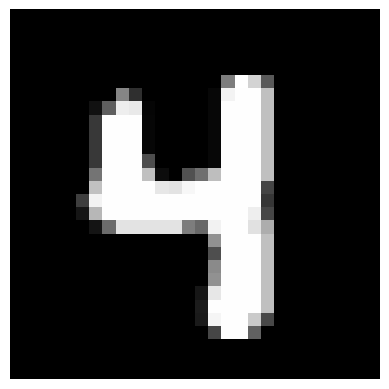

In [50]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [51]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [62]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    ## calc priors, means, and covariances
    for j in range(k):
        indices = (y==j).flatten()
        x_j = x[indices]
        pi[j] = x_j.shape[0]/x.shape[0]
        mu[j] = np.mean(x_j, axis=0)
        sigma[j] = np.cov(x_j.T)
    # Halt and return parameters
    return mu, sigma, pi

In [87]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    # Step 1: Calculate class priors and means (these don't depend on regularization)
    for j in range(k):
        indices = (y == j).flatten()
        x_j = x[indices]
        pi[j] = x_j.shape[0] / x.shape[0]  # Class prior probability
        mu[j] = np.mean(x_j, axis=0)       # Class mean
   # Step 2: Calculate empirical covariance matrices (without regularization yet)
    emp_cov = np.zeros((k, d, d))
    for j in range(k):
        indices = (y == j).flatten()
        x_j = x[indices]
        centered = x_j - mu[j]
        emp_cov[j] = np.dot(centered.T, centered) / x_j.shape[0]
    
    # Step 3: Split data into training and validation sets (80/20 split)
    # This is more efficient than full cross-validation
    np.random.seed(42)
    indices = np.random.permutation(len(y))
    split = int(0.8 * len(y))
    train_idx, val_idx = indices[:split], indices[split:]
    x_train, y_train = x[train_idx], y[train_idx]
    x_val, y_val = x[val_idx], y[val_idx]
    
    # Step 4: Find the best regularization parameter using the validation set
    # Try a range of regularization parameters
    c_values = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]
    best_c = None
    best_error = float('inf')
    
    for c in c_values:
        # Create regularized covariance matrices
        temp_sigma = np.zeros((k, d, d))
        for j in range(k):
            temp_sigma[j] = emp_cov[j] + c * np.eye(d)
        
        # Compute log probabilities for validation set
        val_score = np.zeros((len(y_val), k))
        for label in range(k):
            # Use allow_singular=True to avoid numerical issues
            rv = multivariate_normal(mean=mu[label], cov=temp_sigma[label], allow_singular=True)
            # Vectorized computation for all validation samples at once
            log_likelihoods = rv.logpdf(x_val)
            val_score[:, label] = np.log(pi[label]) + log_likelihoods
        
        val_predictions = np.argmax(val_score, axis=1)
        val_error = np.mean(val_predictions != y_val)
        print(f"Regularization parameter c={c}: validation error = {val_error:.4f}")
        
        if val_error < best_error:
            best_error = val_error
            best_c = c
    
    print(f"Selected best regularization parameter: c={best_c}")
    
    # Step 5: Compute final covariance matrices with the best regularization parameter
    for j in range(k):
        sigma[j] = emp_cov[j] + best_c * np.eye(d)
    
    return mu, sigma, pi

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

Regularization parameter c=0.001: validation error = 0.2134
Regularization parameter c=0.01: validation error = 0.1883
Regularization parameter c=0.1: validation error = 0.1605
Regularization parameter c=1: validation error = 0.1298
Regularization parameter c=10: validation error = 0.0971
Regularization parameter c=100: validation error = 0.0652
Regularization parameter c=1000: validation error = 0.0442
Regularization parameter c=10000: validation error = 0.0537
Selected best regularization parameter: c=1000


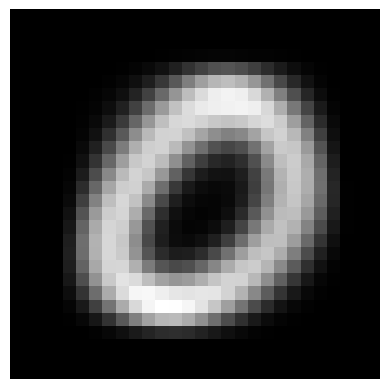

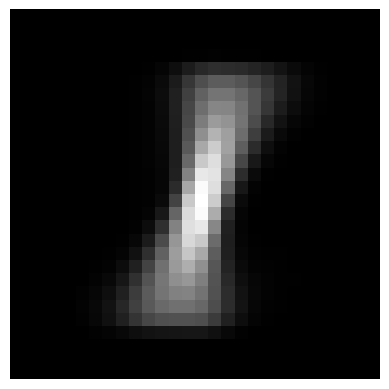

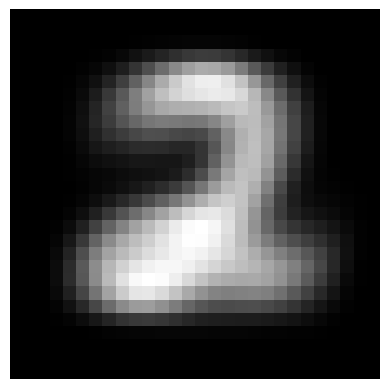

In [88]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [89]:
k=10
# Compute log Pr(label|image) for each [test image,label] pair.
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != test_labels)
print("Your model makes " + str(errors) + " errors out of 10000")

Your model makes 489 errors out of 10000


## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?

<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?

<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the training set?

<font color="magenta">If you have the time</font>: We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?